In [4]:
import numpy as np
from torch import nn
import torch
import netCDF4 as nc
import pandas as pd
import pyproj
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [128]:


N = 14

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(N, 2*N, 3,padding=1),
            nn.Conv2d(2*N, 4*N, 3,padding=1),
            nn.Conv2d(4*N, 2*N, 3, padding=1), 
            nn.Conv2d(2*N, N, 3, padding=1),
            nn.ReLU(N)
        )

    def forward(self, x):
        print(x.shape)
        #x = torch.log(x)
        logits = self.linear_relu_stack(x)
        #logits = torch.exp(logits)
        return logits

In [129]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(14, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(56, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
)


In [130]:
ds = nc.Dataset('nor4km_data\\samples_2020.01.01_nonoverlap.nc')
latlons = (ds['gridLats'], ds['gridLons'])


In [131]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [132]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader) #dataloader is [[X_1, y_1],[X_2, y_2], ..., [X_n, y_n]]
    model.train() #puts model in training mode
    for batch, (X,y) in enumerate(dataloader): #X is input data, y is target data

        #compute prediction
        pred = model(X)
        loss = loss_fn(pred, y)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch *len(X)
            print(f'loss: {loss:>7f} [ {current:>5d}/{size:>5d}]')



In [37]:
def print_on_map(y, latlons, catch_data = None, depth =None, mask = None):
    map = Basemap(projection='merc', llcrnrlon=-15.,llcrnrlat=51.5,urcrnrlon=35.,urcrnrlat=75.,resolution='i' )
    fig = plt.figure()
    fig.set_size_inches(10,10)
    lats, lons = latlons
    print(type(y))
    pred_numpy= y#.detach().numpy()[0,:,:]
    print(pred_numpy.shape)
    temperature = map.contourf(lons, lats,np.ma.masked_array(pred_numpy, mask= mask),100, latlon=True, cmap =plt.cm.RdYlBu_r)
    #temperature = map.contourf(lons, lats,np.ma.masked_array(pred_numpy),100, latlon=True, cmap =plt.cm.RdYlBu_r)
    cb = map.colorbar(temperature,"bottom", size="5%", pad="2%", label="Probability 0-1")
    print(depth.shape)
    print(type(depth))
    map.contour(lons, lats, depth,latlon=True)
    try:  
        map.scatter( catch_data['latitude'], catch_data['longitude'],latlon=True, marker='^')
    except:
        print('Catch data in wrong format')
    map.etopo()
    

In [133]:
epochs = 5
x = np.zeros((N,620,941),dtype=np.float32)
y = np.zeros((1,620,941),dtype=np.float32)
x[0,:,:] = ds.variables['temperature'][12,0:1,:,:]
print(x.shape)
print(type(x[0,0,0]))
dataloader = [[torch.tensor(jan_train),torch.tensor(jan_train_target)]]

(14, 620, 941)
<class 'numpy.float32'>


In [134]:
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------')
    train(dataloader, model, loss_fn, optimizer)
print('Done!')
pred = model(dataloader[0][0])
depth = ds['depth']
print(depth.shape)
max_pred = pred.max()
catch_data = pd.read_csv('cleaned_datasets\herring_catches_2020.csv')




Epoch 1
-------------------------
torch.Size([4697, 14])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [4697, 14]

(620, 941)
(620, 941)
<class 'netCDF4._netCDF4.Variable'>


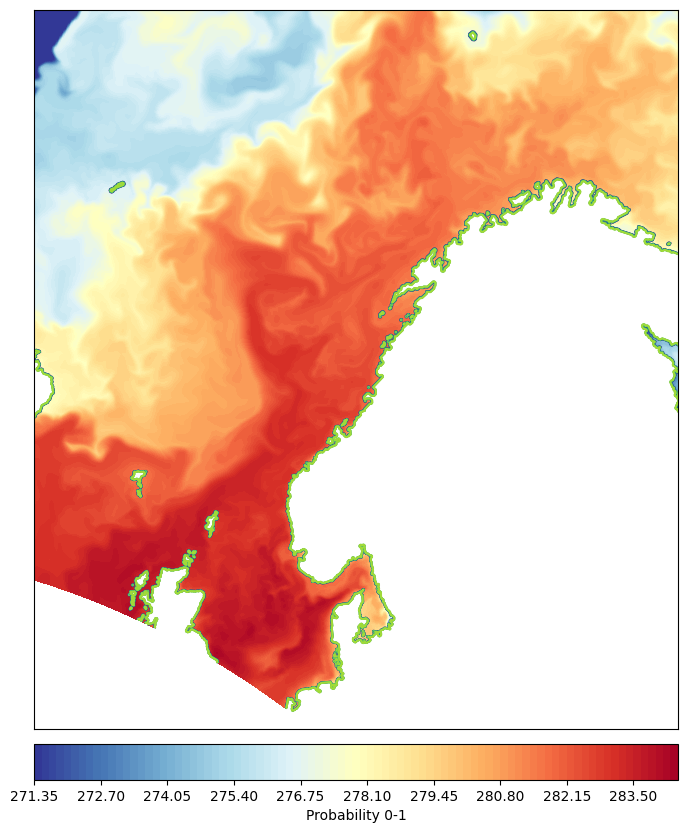

In [118]:
mask = np.load('util\sinmod_land_sea_mask', allow_pickle=True)
plankton = nc.Dataset('plankton_data\samplesb_2020.01.16_nonoverlap.nc')
lats, lons = latlons
map = Basemap(projection='merc', llcrnrlon=-15.,llcrnrlat=51.5,urcrnrlon=35.,urcrnrlat=75.,resolution='i' )
fig = plt.figure()
fig.set_size_inches(10,10)
#print_on_map(plankton['Calanus_finmarchicus'][0,:,:],latlons,depth=depth,catch_data=catch_data, mask = mask)
temp = ds['temperature'][12,0,:,:]
print(temp.shape)
#reshaped = np.reshape(temp, (1, 620*941))
#temp = np.reshape(reshaped, (620, 941))
temperature = map.contourf(lons, lats,temp,100, latlon=True, cmap =plt.cm.RdYlBu_r)
#temperature = map.contourf(lons, lats,np.ma.masked_array(pred_numpy),100, latlon=True, cmap =plt.cm.RdYlBu_r)
cb = map.colorbar(temperature,"bottom", size="5%", pad="2%", label="Probability 0-1")
print(depth.shape)
print(type(depth))
map.contour(lons, lats, depth,latlon=True)


In [100]:
pred.detach().numpy().dump('test_prediction')
import sklearn

In [158]:
jan = np.load('2020_january_6_vars_and_gradients.npy')
#print(jan[:,0])
jan[:,0] -= 275.15
#print(jan[:,0])
jan = sklearn.preprocessing.normalize(jan, axis=0,norm='max')
#jan  =np.load('2020_january_6_vars_and_gradients.npy')
jan_target = np.load('2020_january_target.npy')
#jan_target = np.log(jan_target +1)
jan_train = jan[0::2,:]
jan_train_target= jan_target[0::2]
jan_test = jan[1::2,:]
jan_test_target = jan_target[1::2]
print(jan_train.shape, jan_train_target.shape, jan_test.shape, jan_test_target.shape)
training = np.append(jan_train, np.expand_dims(jan_train_target,1), axis=1)
print(training.shape)
train = h2o.H2OFrame(training)
valid = h2o.H2OFrame(np.append(jan_test, np.expand_dims(jan_test_target,1), axis=1))

[271.3510437  271.3510437  271.35592651 ... 274.36871338 274.38064914
 274.40777588]
[-3.7989563  -3.7989563  -3.79407349 ... -0.78128662 -0.76935086
 -0.74222412]
(4697, 14) (4697,) (4697, 14) (4697,)
(4697, 15)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [155]:
model = LinearRegression()
model.fit(jan_train, jan_train_target)
r_sq = model.score(jan_test, jan_test_target)
print(f"coefficient of determination: {r_sq}")
print(f"slope: {model.coef_}")
print(sklearn.metrics.mean_squared_error(jan_test_target, model.predict(jan_test)))

coefficient of determination: 0.015491952013386157
slope: [   4213.25212097   -3626.41250469  -17687.47237513 -264117.54355618
    6611.02634604    -990.45136213   -1071.17137794  -20249.65581223
   -8848.80284395   -8466.16735561    -529.51935979   19040.78650761
   -2577.8823197    17876.5208109 ]
1035247340.1931294


In [79]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\evenasm\Documents\sild_høst_2022\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\evenasm\AppData\Local\Temp\tmpl3evr57_
  JVM stdout: C:\Users\evenasm\AppData\Local\Temp\tmpl3evr57_\h2o_evenasm_started_from_python.out
  JVM stderr: C:\Users\evenasm\AppData\Local\Temp\tmpl3evr57_\h2o_evenasm_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_evenasm_hi4u6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.953 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [156]:
aml= H2OAutoML(max_models=10, seed=1,nfolds=0)
aml.train(x=[i for i in range(14)], y=14,training_frame=train, validation_frame =valid)

AutoML progress: |
14:33:26.384: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,20857.0,8.0,15.0,10.7,26.0,32.0,28.38
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2022-11-18 14:33:26,0.003 sec,0.0,36731.1171949,15060.7900787,1349174970.3879974,32433.3879885,14434.6055175,1051924656.4155359
,2022-11-18 14:33:26,0.021 sec,5.0,35927.0354058,14476.2109687,1290751873.0478148,31843.2837941,13936.8050783,1013994722.7916529
,2022-11-18 14:33:26,0.039 sec,10.0,35388.4860141,14009.2134819,1252344942.3709810,31483.2400642,13545.2032086,991194404.9425136
,2022-11-18 14:33:26,0.058 sec,15.0,34994.1162617,13732.3956252,1224588172.9360399,31300.7886770,13342.8615920,979739371.8026656
,2022-11-18 14:33:26,0.076 sec,20.0,34723.2704289,13402.9467999,1205705509.2767558,31175.1062117,13051.5979924,971887247.3119985
,2022-11-18 14:33:26,0.093 sec,25.0,34436.8888888,13259.2738192,1185899316.3392255,31059.6248041,12955.2971092,964700292.9710040
,2022-11-18 14:33:26,0.112 sec,30.0,34160.6054633,13201.9213017,1166946965.6179199,30995.4709066,12982.0028660,960719216.7192020
,2022-11-18 14:33:26,0.131 sec,35.0,33904.8750687,13170.4411512,1149540553.4252112,30887.5710269,12991.4448031,954042043.9432744


AttributeError: module 'h2o' has no attribute 'r2'